In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)

In [37]:
def multibox_prior(data,sizes,ratios):
    height, width = data.shape[-2:]
    device , num_sizes, num_ratios =data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes+num_ratios-1)
    size_tensor=torch.tensor(sizes,device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    #Offsets are required to move the anchor to the center of the pixel
    #Pixel has 1 unit of height and 1 unit of width, we need to move by 0.5 
    offset_h, offset_w= 0.5, 0.5
    steps_h = 1.0/height # convering into untis in y-axis
    steps_w = 1.0/width #converting into units in x-axis
    
    #Generate all center points for the anchor box
    c_h = (torch.arange(height,device=device)+offset_h)*steps_h
    c_w = (torch.arange(width,device=device)+offset_w)*steps_w
    #create a grid 
    shift_y, shift_x = torch.meshgrid(c_h,c_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    
    
    #Generate boxes_per_pixel number of heights and widths that are later used 
    #create anchox box corner coordinates (xmin, xmax, ymin, ymax)
    
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * height / width
    
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    print(h)
    print(w)
    anchor_manipulations = torch.stack((-w,-h,w,h)).T.repeat(height*width,1)/2
    
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],dim=1).repeat_interleave(boxes_per_pixel,dim=0)
    output=out_grid+anchor_manipulations
    return output.unsqueeze(0)


In [38]:
img= d2l.plt.imread('img/dogbaby.jpg')
h, w = img.shape[:2]

#print(c_h)
X = torch.rand(size=(1,3,h,w))# I am not sure why 1 and 3
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape


tensor([0.75, 0.50, 0.25, 0.53, 1.06])
tensor([0.42, 0.28, 0.14, 0.60, 0.30])


torch.Size([1, 1152000, 4])

In [40]:
boxes = Y.reshape(h,w,5,4)
boxes[250,250,0,:]

tensor([0.18, 0.32, 0.60, 1.07])

In [49]:
def show_box(axes,bboxes,labels=None,colors=None):
    def make_list(obj,default_values=None):
        if obj is None:
            obj=default_values
        elif not isinstance(obj,(list,tuple)):
            obj=[obj]
        return obj
    
    labels = make_list(labels)
    colors = make_list(colors, ['b','g','m','c'])
    for i,bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect (bbox.detach().numpy(),color)
        axes.add_patch(rect)
        if labels and len(labels)>i:
            text_color = 'k' if color =='w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                      ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

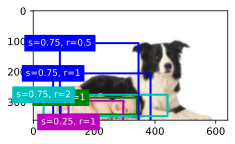

In [54]:
d2l.set_figsize()
bbox_scale = torch.tensor((h,w,w,h))
fig = d2l.plt.imshow(img)
show_box(fig.axes, boxes[250, 250, :, :] * bbox_scale, [
    's=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'
])

In [ ]:
def box_iou(boxes1, boxes2):
    box_area = lambda boxel: